# Describing the Combined Files and Defining Research Questions
#### Jameson Carter, Mihir Bhaskar, Abhilash Biswas
#### 11/26/2021
The following code evaluates a joined file created in CombineData.ipynb. This file contains ACS tracts in Chicago and demographic information, complaints made against police officers in those locations, and geographic information about the city of chicago, within those tracts. 

In this file, we-

 - Provide some initial visualizations that describe this dataset.
 - Define some of our prediction variables, alongside some of our research questions.
 - Run a preliminary test

## Describe the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 

import statsmodels.formula.api as smf


In [2]:
data = pd.read_csv(here('./data/Combined.csv'))

### Evaluating the Target Variable- Complaints

Text(0.5, 1.0, 'Complaints in Chicago')

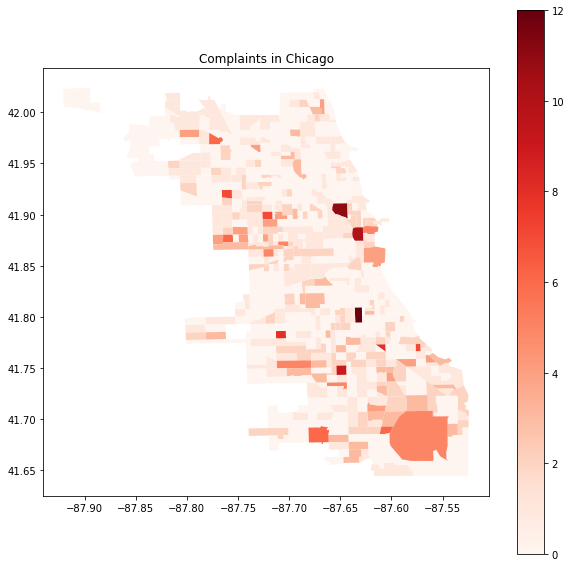

In [3]:
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
plt.rcParams['figure.figsize'] = [10, 10]
GeoData = gpd.GeoDataFrame(data, geometry='geometry')
GeoData.plot("complaint_count", cmap = "Reds", legend = True)
plt.title('Complaints in Chicago')

The above plot shows that there are a few tracts where complaints are quite high, although there is not a clear geographic relationship. There seem to be higher numbers of complaints on the South Side of the city. 

The plot flags a few tracts as having particularly high complaint incididence:
 - Tract 8356 (12), which is a small tract nestled between a large highway and a railyard on the South side, with a police station nearby.
 - Tract 8422 (11), which is a larger tract containing Goose Island, an island bounded by a canal and a river near a historically poor neighborhood called Cabrini-Green.
 - Tract 1839 (10), is a larger tract nestled between the Chicago River and Lake Michigan, and is nearby the Art Institute of Chicago.
 
I evaluated these tracts using the following https://www.chicagocityscape.com/maps/?place=censustract-17031835600

In [4]:
GeoData.sort_values('complaint_count', ascending = False).head(3)

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count
728,1400000US17031835600,896.0,16.5,3.5,39.8,40.2,14.4,60.2,2.08,20.3,...,120.0,0.0,0.0,11.0,88.0,5.0,2.0,482.0,62.0,35.0
781,1400000US17031842200,3362.0,18.2,9.6,36.8,35.4,10.0,18.5,1.62,9.8,...,144.0,0.0,0.0,18.0,118.0,21.0,1.0,2928.0,15.0,80.0
755,1400000US17031839100,7545.0,22.9,8.6,42.6,25.8,4.7,5.2,1.61,6.5,...,604.0,2.0,5.0,158.0,580.0,70.0,18.0,11704.0,26.0,47.0


The following exploration finds that the typical tract (as defined by the median), exhibits no complaints, while the average tract exhibits 0.83 complaints.

In [5]:
GeoData[['complaint_count']].describe()

,complaint_count
count,798.000000
mean,0.810777
std,1.383913
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,12.000000


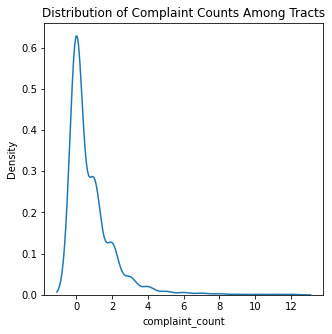

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(GeoData['complaint_count'])
plt.title('Distribution of Complaint Counts Among Tracts')
plt.show()

### Evaluating relationships between variables

The code below creates a correlation matrix for the dataset, and filters it to those variables with the absolute value of correlation greater than 80% (since there are too many variables to visualize in a complete correlation matrix).

In [7]:
# Moving the target variables so they are at the front of the dataset
target = GeoData.pop('complaint_count')
GeoData.insert(loc=0, column='complaint_count', value=target)

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = GeoData.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)


#corr_triu.sort_values(by=['Correlation Coefficient'], inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu


Number of feature pairs that are highly correlated (i.e. >80%): 57


,,Correlation Coefficient
Col1,Col2,
ASSAULT,BATTERY,0.963624
DECEPTIVE PRACTICE,THEFT,0.953793
ASSAULT,OTHER OFFENSE,0.940364
DP02_0015PE,DP03_0066PE,0.940157
BATTERY,OTHER OFFENSE,0.936715
DP03_0004PE,DP03_0013PE,0.925954
DP05_0037PE,DP05_0038PE,-0.923312
DP02_0093PE,DP02_0114PE,0.917271
BATTERY,CRIMINAL DAMAGE,0.914779


There are several feature pairs, predominantly from the ACS data, that are highly correlated - 28 feature pairs have an absolute correlation coefficient greater than 80%. Some of these variables will need to be dropped based on some other criterion before any modelling efforts.

Some of the other pairs that are highly correlated are:
- % of households with social security and households with a member 65+.
- % of population that is employed and % of women who are employed.
- % of population that is white and % of population that is black.
- % of population born abroad and % of population who do not speak English at home, and who do not speak English 'very well.'

Several of these variables will need to be dropped in the modelling effort through selection methods and cleaning. Some are near-mirrors as they account for similar elements to the same issue. 

**The code below now looks at spatial distributions of a few predictors**, to see if there are any geographic patterns

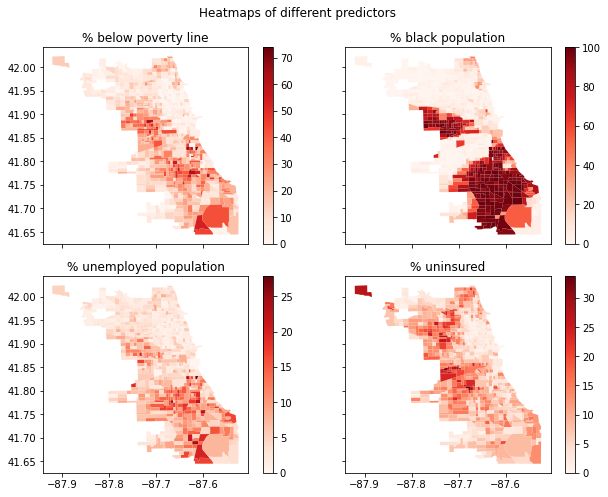

In [8]:
# Variables to create plots for in a loop
variables = ['DP03_0119PE', 'DP05_0038PE', 'DP03_0005PE', 'DP03_0099PE']
titles = ['% below poverty line', '% black population', '% unemployed population', '% uninsured']

# Set up the subplots in a 2x2 grid and initialise the figure
fig, axes = plt.subplots(2,2, figsize=(9,7), sharex=True, sharey=True)
fig.suptitle('Heatmaps of different predictors')

# Loop through both the degree (range from 1-7), and the tile we want the plot in (from the axes)
i = -1
for var, ax in zip(variables, axes.flatten()):
    
    # Create heatmap plot
    GeoData.plot(var, cmap='Reds', legend=True, ax=ax)
    
    # Give it a title according to the titles list
    i += 1
    ax.set_title('{:s}'.format(titles[i]))

plt.tight_layout()

The plots show:
- A concentration of tracts with a high % of black families and individuals in the south side of the city
- Individuals below the poverty line, and unemployment rates follow a very similar geographic pattern, and are also starker towards the center and south sides of the city
- It is harder to discern a clear pattern in health insurance, although it appears that the largest incidence of uninsurance are in the segments of the city where non-white populations live, as well as a significant population of people without insurance in the whiter areas of the city.

These plots seem to suggest that there are groupings of tracts that share similar characteristics. This informs our third research question, of wanting to explore unsupervised learning to uncover naturally occuring clusters of tracts based on their characteristics.

In [9]:
nan_values = GeoData.isna()
nan_columns = nan_values.any()

columns_with_nan = GeoData.columns[nan_columns].tolist()
columns_with_nan

[]

## Research Question 1

#### Predicting the use of force complaint rate in Chicago Census tracts

###### Why: Evaluate which tracts may have a high complaint rate and direct policy attention towards those tracts

### Preliminary prediction model - Checking the prediction accuracy and generalisibility of a linear model containing all possible predictors in the dataset (kitchen sink prediction model)




In [10]:
#Remove any columns with all null values
GeoData = GeoData.dropna(axis=1)
GeoData

,complaint_count,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count
0,0.0,1400000US17031010100,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,...,198.0,0.0,0.0,18.0,84.0,8.0,3.0,467.0,43.0,3.0
1,0.0,1400000US17031010201,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,...,138.0,0.0,0.0,8.0,70.0,15.0,0.0,431.0,18.0,18.0
2,1.0,1400000US17031010202,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,...,76.0,0.0,0.0,6.0,94.0,15.0,2.0,786.0,14.0,16.0
3,0.0,1400000US17031010300,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,...,129.0,0.0,1.0,3.0,73.0,20.0,4.0,534.0,6.0,9.0
4,0.0,1400000US17031010400,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,...,97.0,0.0,0.0,5.0,40.0,10.0,2.0,390.0,10.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1.0,1400000US17031843500,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,...,133.0,0.0,1.0,12.0,33.0,8.0,0.0,537.0,22.0,40.0
794,1.0,1400000US17031843600,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,...,132.0,0.0,1.0,5.0,91.0,8.0,0.0,412.0,14.0,35.0
795,3.0,1400000US17031843700,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,...,76.0,1.0,0.0,12.0,29.0,9.0,2.0,416.0,4.0,77.0
796,1.0,1400000US17031843800,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,...,131.0,1.0,0.0,14.0,67.0,4.0,3.0,293.0,35.0,41.0


In [68]:
#Creating X and y dataframes
df_y = GeoData['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
# Additionally, remove complaint count, variable used to create complaint rate
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_X = df_X.select_dtypes(['number']) 

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      
                                                                                        
#Fitting model
lm_r1 = LinearRegression()
lm_r1.fit(X_train, y_train)

#Calculating MSE
MSE_train  = mean_squared_error(y_train, lm_r1.predict(X_train))
print("Training R-squared: ", lm_r1.score(X_train, y_train))
print("MSE train: " , MSE_train)

MSE_test  = mean_squared_error(y_test, lm_r1.predict(X_test))
print("Testing R-squared: ", lm_r1.score(X_test, y_test))
print("MSE test: " , MSE_test)

Training R-squared:  0.5084230909142482
MSE train:  0.8914538390935901
Testing R-squared:  0.05799646748490461
MSE test:  2.1723484588109834


Commentary: We have a likely overfitted model, but it's useful to see how well the model is fitting from this kitchen sink linear regression. 



OLD REGRESSION (BEFORE CHANGES TO OPEN DATA)
The training R squared is ~54%, however the testing R squared drops to 37%. This is a signal of overfitting. 
By and large, for this exploratory exercise, the key takeaway is that in the training set at least, the predictors are able to explain 53% of the variation in the training set. This is a bad performance, as far as we can tell.

In [66]:
#Checking if adding all crime types into 1 gives a better result
df_X['total_crimes'] = df_X.iloc[:,87:121].sum(axis=1)
df_X = df_X.drop(columns =list(df_X.columns[87:121]) )
df_X

,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,DP02_0026PE,...,DP05_0058PE,DP05_0071PE,police_stations,fire_stations,public_schools,parks,commercial_establishments,number_of_police_killings,inv_stop_count,total_crimes
0,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,25.4,64.4,...,3.4,11.4,1,1,14,14,24.0,0.0,3.0,2888.0
1,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,34.5,55.3,...,8.0,22.4,1,3,17,18,30.0,0.0,18.0,2104.0
2,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,25.1,58.8,...,1.4,26.0,1,3,16,18,58.0,0.0,16.0,2191.0
3,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,20.0,49.6,...,4.2,16.9,1,2,15,17,71.0,0.0,9.0,1889.0
4,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,16.8,75.1,...,1.8,7.5,1,2,17,12,41.0,0.0,39.0,1371.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,44.1,88.4,...,0.0,26.3,1,5,57,4,122.0,0.0,40.0,1636.0
794,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,32.5,48.1,...,2.4,7.9,2,6,44,20,42.0,0.0,35.0,1815.0
795,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,32.6,35.4,...,6.4,25.7,1,6,41,13,118.0,1.0,77.0,1176.0
796,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,31.1,50.6,...,0.5,7.0,2,6,46,11,32.0,0.0,41.0,1651.0


In [67]:
#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      
                                                                                        
#Fitting model
lm_r1 = LinearRegression()
lm_r1.fit(X_train, y_train)

#Calculating MSE
MSE_train  = mean_squared_error(y_train, lm_r1.predict(X_train))
print("Training R-squared: ", lm_r1.score(X_train, y_train))
print("MSE train: " , MSE_train)

MSE_test  = mean_squared_error(y_test, lm_r1.predict(X_test))
print("Testing R-squared: ", lm_r1.score(X_test, y_test))
print("MSE test: " , MSE_test)

Training R-squared:  0.411214126365009
MSE train:  1.0677381662050884
Testing R-squared:  -0.04146834394203225
MSE test:  2.4017236387875713


### Improving the regression model

In [12]:
#First splitting the entire dataset into model building and validation set
df_validation = GeoData.sample(frac = 0.2, random_state = 1)

df_model = GeoData.drop(df_validation.index)

In [13]:
#Creating train and test sets for the modelling dataset
df_model_y = df_model['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
# Additionally, remove complaint count, variable used to create complaint rate
df_model_X = df_model.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_model_X = df_model_X.select_dtypes(['number']) 


In [18]:
#Now selecting 30 best predictors using forward stepwise
model= LinearRegression()
sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = 30, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv= 10) 

sfs = sfs.fit(df_model_X,df_model_y)
feature_names = np.array(df_model_X.columns)
print("# of features : ",30)
print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))

predictor_subset = list((feature_names[sfs.get_support()]))
df_subset = df_model_X[predictor_subset]
    
score = np.mean(cross_val_score(model,df_subset, df_model_y, scoring='neg_mean_squared_error', cv = 10))
print("CV score: ", score)



# of features :  30
Features selected by forward sequential selection: ['DP02_0026PE' 'DP02_0054PE' 'DP02_0074PE' 'DP02_0085PE' 'DP02_0153PE'
 'DP03_0029PE' 'DP03_0030PE' 'DP03_0031PE' 'DP03_0119PE' 'DP04_0003PE'
 'DP04_0069PE' 'DP04_0073PE' 'DP04_0136PE' 'DP05_0044PE' 'police_stations'
 'fire_stations' 'commercial_establishments' 'number_of_police_killings'
 'ARSON' 'ASSAULT' 'CRIMINAL SEXUAL ASSAULT'
 'INTERFERENCE WITH PUBLIC OFFICER' 'INTIMIDATION' 'NON - CRIMINAL'
 'NON-CRIMINAL' 'OFFENSE INVOLVING CHILDREN' 'PUBLIC INDECENCY'
 'PUBLIC PEACE VIOLATION' 'ROBBERY' 'WEAPONS VIOLATION']
CV score:  -1.3693637508283478


I also ran this model to check the following number of predictors and got the following values:
10 - 1.45
20 - 1.37
30 - 1.369
40 - 1.368
60 - 1.62

In [72]:
#Now trimming our datasets to only contain these predictors

#Validation set
df_validation_y = df_validation['complaint_count']

df_validation_X = df_validation.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_validation_X = df_validation_X.select_dtypes(['number']) 
df_validation_X = df_validation_X[predictor_subset]

#Modelling set
df_model_X = df_model_X[predictor_subset]

In [73]:
df_model_X

,DP02_0026PE,DP02_0054PE,DP02_0074PE,DP02_0085PE,DP02_0153PE,DP03_0029PE,DP03_0030PE,DP03_0031PE,DP03_0119PE,DP04_0003PE,...,CRIMINAL SEXUAL ASSAULT,INTERFERENCE WITH PUBLIC OFFICER,INTIMIDATION,NON - CRIMINAL,NON-CRIMINAL,OFFENSE INVOLVING CHILDREN,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,WEAPONS VIOLATION
0,64.4,17.2,6.4,1.8,75.7,15.3,1.6,17.3,26.5,10.2,...,3.0,17.0,0.0,0.0,0.0,33.0,0.0,18.0,84.0,43.0
1,55.3,2.8,1.5,1.5,76.1,20.7,3.8,16.7,28.6,7.9,...,0.0,9.0,1.0,0.0,1.0,24.0,0.0,8.0,70.0,18.0
2,58.8,16.6,3.4,2.8,80.9,23.3,4.3,14.2,16.4,10.4,...,2.0,9.0,0.0,0.0,0.0,9.0,0.0,6.0,94.0,14.0
4,75.1,1.1,2.5,13.8,81.0,21.4,1.6,5.3,13.9,10.7,...,2.0,4.0,0.0,0.0,0.0,5.0,0.0,5.0,40.0,10.0
5,56.0,2.8,0.0,2.7,70.4,15.8,0.0,14.4,18.8,11.0,...,2.0,1.0,0.0,0.0,0.0,7.0,0.0,1.0,41.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,88.4,1.8,1.9,1.8,71.9,29.8,8.7,21.5,41.3,14.2,...,0.0,7.0,9.0,0.0,0.0,6.0,1.0,12.0,33.0,22.0
794,48.1,19.3,2.9,7.2,77.8,16.2,7.2,6.6,11.9,10.7,...,1.0,4.0,0.0,0.0,0.0,16.0,1.0,5.0,91.0,14.0
795,35.4,10.4,0.0,2.3,85.1,22.3,1.5,7.9,0.0,1.2,...,2.0,5.0,4.0,0.0,1.0,3.0,0.0,12.0,29.0,4.0
796,50.6,2.2,12.9,0.6,69.1,23.9,10.6,21.7,17.0,19.3,...,4.0,17.0,1.0,0.0,0.0,14.0,0.0,14.0,67.0,35.0


In [21]:
#Now finding the best polynomial model
for i in range(1,4):
    poly_model = PolynomialFeatures(degree = i)
    
    X_poly_train = poly_model.fit_transform(df_model_X)

    lm_poly = LinearRegression()
    lm_poly.fit(X_poly_train, df_model_y)
    
    CV_score = np.mean(cross_val_score(lm_poly,X_poly_train,df_model_y,cv = 10, scoring = 'neg_mean_squared_error'))
    
    print("Degree: ",i)
    print("Avg CV score: ",CV_score)


Degree:  1
Avg CV score:  -1.3709704753848146
Degree:  2
Avg CV score:  -188.8057545224204
Degree:  3
Avg CV score:  -160359.7367255565


We can see that a linear regression would be the best one to go with in this case. 

In [22]:
#Checking if a ridgeCV model works better
#Setting a range of alphas
alphas = np.logspace(-5, 5, 100)

#Fitting model
model_ridgeCV = RidgeCV(cv=10, alphas = alphas, scoring = "neg_mean_squared_error").fit(df_model_X, df_model_y)

#Printing scores
print("Ridge regression")
print("Ridge - best_score: \n",model_ridgeCV.best_score_)
print("Ridge - best alpha: "+str(model_ridgeCV.alpha_))


#To compare with a plain linear model
linear_model = LinearRegression()
linear_model.fit(df_model_X,df_model_y)
score = np.mean(cross_val_score(model,df_model_X,df_model_y, scoring = 'neg_mean_squared_error',cv = 10))
print("linear model CV score :", score)

Ridge regression
Ridge - best_score: 
 -1.3686034387382733
Ridge - best alpha: 2.2570197196339215
linear model CV score : -1.3693637508283478


Since the ridgeCV and linear model give pretty much the same CV score, let's stick with linear model to keep it simple. But below, I check for Lasso CV as well

In [23]:
model_lassoCV = LassoCV(cv=10).fit(df_model_X,df_model_y)

print("Lasso - R-squared: "+str(model_lassoCV.score(df_model_X,df_model_y)))
print("Lasso - best alpha: "+str(model_lassoCV.alpha_))


Lasso - R-squared: 0.3661333831102481
Lasso - best alpha: 0.1331808502274939


In [71]:
df_validation_X

,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,DP02_0026PE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count
8,6395.0,28.6,11.4,26.3,33.8,14.2,11.3,2.12,19.4,58.8,...,116.0,0.0,0.0,10.0,72.0,8.0,1.0,473.0,16.0,39.0
509,4148.0,22.5,2.2,25.4,49.9,22.4,42.8,2.78,37.2,57.0,...,336.0,28.0,0.0,25.0,130.0,16.0,2.0,381.0,150.0,31.0
175,5882.0,33.7,12.4,29.2,24.7,36.5,13.6,2.93,31.9,51.7,...,82.0,0.0,1.0,17.0,80.0,10.0,0.0,344.0,37.0,32.0
366,3035.0,39.9,13.3,12.5,34.4,55.7,20.7,3.77,42.8,55.5,...,79.0,0.0,0.0,15.0,48.0,10.0,1.0,154.0,18.0,46.0
242,2841.0,43.3,5.4,17.8,33.5,21.8,21.3,2.88,27.4,48.4,...,33.0,2.0,0.0,3.0,43.0,7.0,0.0,200.0,10.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,3668.0,29.4,4.7,23.4,42.5,24.1,13.8,2.23,26.4,41.9,...,94.0,4.0,0.0,2.0,22.0,5.0,0.0,245.0,6.0,39.0
663,5262.0,16.9,4.9,27.6,50.6,24.9,36.4,2.33,30.6,56.8,...,293.0,0.0,0.0,13.0,152.0,13.0,3.0,769.0,60.0,17.0
712,7436.0,32.6,9.2,22.0,36.2,16.5,8.9,1.82,16.2,50.1,...,193.0,0.0,0.0,25.0,101.0,8.0,3.0,1515.0,3.0,27.0
594,5434.0,25.2,4.6,22.3,47.9,32.0,35.5,2.86,32.5,58.7,...,318.0,0.0,0.0,20.0,137.0,8.0,1.0,643.0,89.0,38.0


In [74]:
#Now let's check how well this model performs against the validation set
linear_model = LinearRegression()
final_model = linear_model.fit(df_model_X,df_model_y)


final_model_score = final_model.score(df_validation_X,df_validation_y)
CV_test_score = np.mean(cross_val_score(final_model,df_validation_X,df_validation_y, 
                                        scoring = 'neg_mean_squared_error',cv = 10))

print("OLS")
print("R squared: ", final_model_score)
print("CV score on test dataset: ", CV_test_score)


#Checking the same for Ridge model
print("Ridge")
ridge_model_score = model_ridgeCV.score(df_validation_X,df_validation_y)
print("R squared: ", ridge_model_score)

#Checking for Lasso model
print("Lasso")
lasso_model_score = model_lassoCV.score(df_validation_X,df_validation_y)
print("R squared: ", lasso_model_score)

OLS
R squared:  0.027079836356146858
CV score on test dataset:  -1.089813819231146
Ridge
R squared:  0.029438020870676262
Lasso
R squared:  0.12893661026082492


In [75]:
#Trying a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rd = RandomForestRegressor(n_estimators = 400, max_depth = 30, random_state = 1)
rd.fit(df_model_X,df_model_y)

y_pred=rd.predict(df_validation_X)

train_score = rd.score(df_model_X,df_model_y)
test_score = rd.score(df_validation_X,df_validation_y)

print("Train r sqaured", train_score)
print("Test r sqaured", test_score)



Train r sqaured 0.8909445130575057
Test r sqaured 0.0774049767569045


In [81]:
GeoData[GeoData['police_stations'] == 0]

,complaint_count,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count
143,1.0,1400000US17031090100,3509.0,52.7,2.5,21.3,23.5,29.6,32.7,2.46,...,34.0,1.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,6.0
144,1.0,1400000US17031090200,6416.0,56.1,3.4,16.4,24.2,24.7,27.5,2.34,...,74.0,0.0,0.0,8.0,6.0,6.0,1.0,150.0,2.0,16.0
145,0.0,1400000US17031090300,1339.0,54.8,4.1,18.3,22.9,33.5,29.8,2.72,...,18.0,0.0,0.0,2.0,3.0,0.0,0.0,35.0,0.0,10.0
147,1.0,1400000US17031100200,6819.0,43.8,2.0,16.7,37.5,24.7,27.3,2.32,...,76.0,0.0,0.0,3.0,10.0,6.0,1.0,236.0,5.0,41.0
148,1.0,1400000US17031100300,6259.0,48.2,2.9,14.7,34.2,19.2,48.8,2.22,...,54.0,0.0,0.0,10.0,2.0,12.0,2.0,223.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.0,1400000US17031821402,2992.0,21.3,4.6,26.1,48.0,17.5,35.9,2.04,...,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,2.0,14.0
688,0.0,1400000US17031830500,3901.0,56.0,5.3,21.4,17.3,48.7,43.6,3.59,...,88.0,0.0,0.0,12.0,60.0,9.0,0.0,231.0,21.0,58.0
726,0.0,1400000US17031835200,1993.0,44.0,9.5,31.1,15.5,29.7,28.8,2.99,...,59.0,4.0,0.0,3.0,33.0,1.0,0.0,255.0,8.0,35.0
780,1.0,1400000US17031842100,7865.0,36.6,3.9,15.9,43.6,58.6,25.8,3.61,...,308.0,3.0,0.0,17.0,203.0,15.0,3.0,642.0,101.0,49.0


### Trying classification

### Preliminary classification model - Checking whether a kitchen sink classification model performs better than a prediction model. 

We will classify complaint rate into Any complaints (1) and no complaints (0). It appears that there are 454 tracts without complaints of use-of-force and 344 with complaints of use-of-force. This seems decently well-balanced.

In [38]:
#Creating datasets
df_c_model_y = pd.DataFrame(df_model_y)

df_c_model_y['any_complaints'] = np.where(df_c_model_y['complaint_count']>0, 1, 0)
df_c_model_y = df_c_model_y['any_complaints']
df_c_model_y

df_c_validation_y = pd.DataFrame(df_validation_y)

df_c_validation_y['any_complaints'] = np.where(df_c_validation_y['complaint_count']>0, 1, 0)
df_c_validation_y = df_c_validation_y['any_complaints']
df_c_validation_y




8      1
509    1
175    0
366    0
242    1
      ..
358    0
663    0
712    1
594    1
108    0
Name: any_complaints, Length: 160, dtype: int64

              precision    recall  f1-score   support

           0      0.670     0.856     0.751        90
           1      0.711     0.457     0.557        70

    accuracy                          0.681       160
   macro avg      0.690     0.656     0.654       160
weighted avg      0.688     0.681     0.666       160



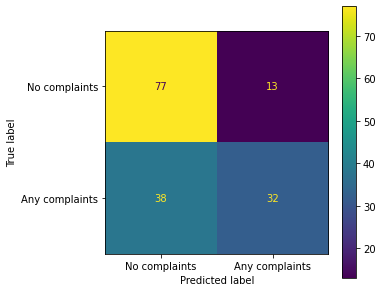

In [28]:
#Creating the classification model (1)


#Importing class
from sklearn.naive_bayes import GaussianNB

#Defining model
model = GaussianNB()
nb_pred = model.fit(df_model_X,df_c_model_y).predict(df_validation_X) 
print(classification_report(df_c_validation_y,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,nb_pred) 
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

                                                                                        


              precision    recall  f1-score   support

           0      0.611     0.856     0.713        90
           1      0.618     0.300     0.404        70

    accuracy                          0.613       160
   macro avg      0.614     0.578     0.558       160
weighted avg      0.614     0.613     0.578       160



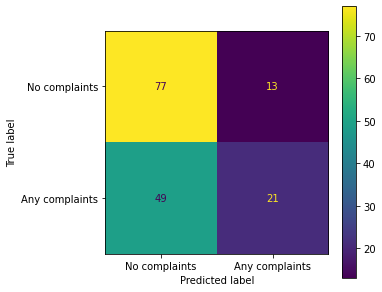

In [29]:
#Creating a KNN model
knn = KNeighborsClassifier(n_neighbors = 10)  
knn.fit(df_model_X,df_c_model_y)
KNeighborsClassifier()

#Predicting test values
y_pred = knn.predict(df_validation_X)
y_pred

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,y_pred)
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

#Classification report
print(classification_report(df_c_validation_y,y_pred,digits = 3))


Commentary: We see that a Naive Bayesian classification model has quite low accuracy in predicting whether a tract has any complaints or not. This is an initial indication that our model may be affected by irrelevant variables and hence we should apply subsetting methods to keep only a subset of the full predictor list. 

From this, we can see that out

              precision    recall  f1-score   support

           0      0.658     0.833     0.735        90
           1      0.674     0.443     0.534        70

    accuracy                          0.662       160
   macro avg      0.666     0.638     0.635       160
weighted avg      0.665     0.662     0.647       160



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


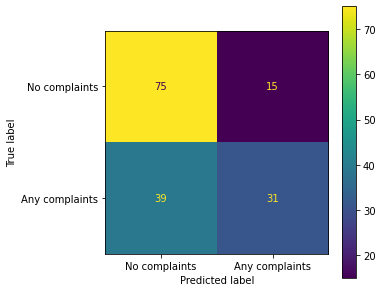

In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model_pred = model.fit(df_model_X,df_c_model_y).predict(df_validation_X) 
cm = confusion_matrix(df_c_validation_y,model_pred) 

dissplay_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['No complaints','Any complaints'])
dissplay_cm.plot()
print(classification_report(df_c_validation_y, model_pred, digits=3))

In [31]:
#Sure, Random Forest. Why not?
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 1)
clf_rf.fit(df_model_X,df_c_model_y)

y_pred_rf = clf_rf.predict(df_validation_X)

print(classification_report(df_c_validation_y,y_pred_rf,digits = 3))



              precision    recall  f1-score   support

           0      0.685     0.822     0.747        90
           1      0.692     0.514     0.590        70

    accuracy                          0.688       160
   macro avg      0.689     0.668     0.669       160
weighted avg      0.688     0.688     0.679       160



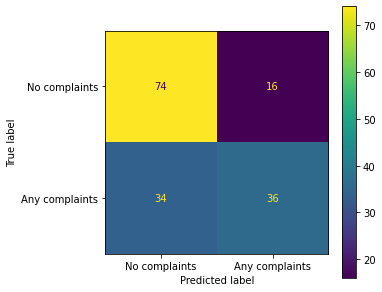

In [32]:
cm = confusion_matrix(df_c_validation_y,y_pred_rf) 

dissplay_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['No complaints','Any complaints'])

dissplay_cm.plot()

In [33]:
#Checking how classification works when we include all variables
#Creating train and test sets for the modelling dataset
df_model_y = df_model['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
# Additionally, remove complaint count, variable used to create complaint rate
df_model_X = df_model.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_model_X = df_model_X.select_dtypes(['number']) 

df_validation_y = df_validation['complaint_count']

df_validation_X = df_validation.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 




              precision    recall  f1-score   support

           0      0.653     0.856     0.740        90
           1      0.690     0.414     0.518        70

    accuracy                          0.662       160
   macro avg      0.672     0.635     0.629       160
weighted avg      0.669     0.662     0.643       160



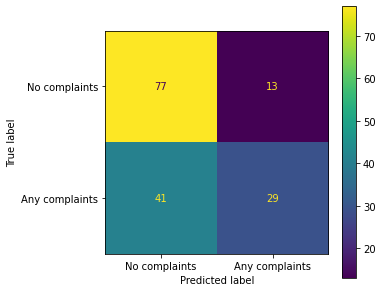

In [39]:
#Defining model
model = GaussianNB()
nb_pred = model.fit(df_model_X,df_c_model_y).predict(df_validation_X) 
print(classification_report(df_c_validation_y,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,nb_pred) 
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()


Classifying on all variables doesn't improve scores. 

## Research Question 3

### a) Can we effectively cluster census tracts into groups having similar characteristics (unsupervised learning)
### b) Do census tracts in a given cluster have similar outcomes in terms of use of force complaints

#### This analysis would allow us to evaluate whether tracts that have similar outcomes (from b) also have similar characteristics. 

##### NOTE: We will explore and analyse this research question as a part of our final submission

In [63]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer

In [46]:
df_y = GeoData['complaint_count']
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 
df_X = df_X.select_dtypes(['number']) 

Next, we need to determine the optimal number of K for our clustering model. For this preliminary exploration, we will only use this method to choose K, but will take a more extensive approach in the future. This approach finds that the optimal K is equal to 5.

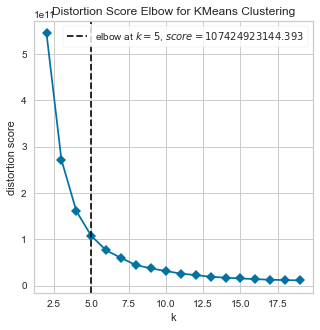

In [47]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False).fit(df_X)
visualizer.show(); 

It looks like our clusters are not properly separated, as there is overlap between the clusters at k = 5.

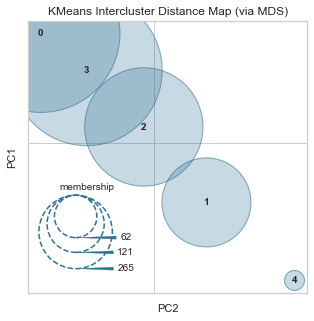

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [64]:
tunedmod = KMeans(random_state=1, n_clusters=5).fit(df_X)
visualizer = InterclusterDistance(tunedmod).fit(df_X)
visualizer.show()  

The following plot shows that two clusters, cluster 1 and 4 are quite small (the two clusters that were most seperable from the above plot). This is not necessarily a good thing, although all silhouette coefficients are greater than average and closer to 1 than 0, which is a better sign.

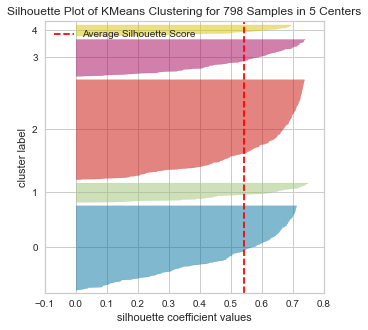

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 798 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [215]:
visualizer = SilhouetteVisualizer(tunedmod, colors='yellowbrick').fit(df_X)
visualizer.show()

Now that we have our K means model, lets evaluate the qualities of our response variable, as well as of a few variables of interest to see how clusters correlate to those respective variables.

In [65]:
pred = tunedmod.predict(df_X)
GeoData['cluster_label'] = pd.Series(pred, index=df_X.index)

In [66]:
print('Complaint Count by cluster:\n',GeoData.groupby('cluster_label').describe()['complaint_count'])
print('\nPolice stops by cluster:\n', GeoData.groupby('cluster_label').describe()['inv_stop_count'])
print('\nPercentage in Poverty by cluster:\n', GeoData.groupby('cluster_label').describe()['DP03_0119PE'])

Complaint Count by cluster:
                count      mean       std  min  25%  50%  75%   max
cluster_label                                                     
0              314.0  1.098726  1.586625  0.0  0.0  1.0  2.0  12.0
1               62.0  0.806452  1.576869  0.0  0.0  0.0  1.0  10.0
2              121.0  0.479339  1.148181  0.0  0.0  0.0  1.0  11.0
3              265.0  0.686792  1.175836  0.0  0.0  0.0  1.0   8.0
4               36.0  0.333333  0.585540  0.0  0.0  0.0  1.0   2.0

Police stops by cluster:
                count       mean        std   min    25%   50%   75%   max
cluster_label                                                            
0              314.0  31.907643  12.549241   3.0  24.00  30.0  38.0  86.0
1               62.0  38.032258  14.499257   6.0  29.50  35.5  49.0  77.0
2              121.0  34.272727  14.714505   6.0  25.00  34.0  42.0  80.0
3              265.0  33.211321  12.795028   1.0  25.00  34.0  41.0  77.0
4               36.0  39.027778

From the above exploration, it appears that complaint counts vary on average by a somewhat small amount (from 0.3 to 1.1), as do police stops (from 31.9 to 39.1), although poverty varies widely. Cluster 0 at the mean showed a 27% poverty rate at the average, while clusters 4, 1, and 2 exhibited average poverty rates of 5% or less. 

## Sources

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 - The in class exercise Clustering-Mini2_JamsonCarter.ipynb
 - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
 - https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python
 - https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
 - https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns